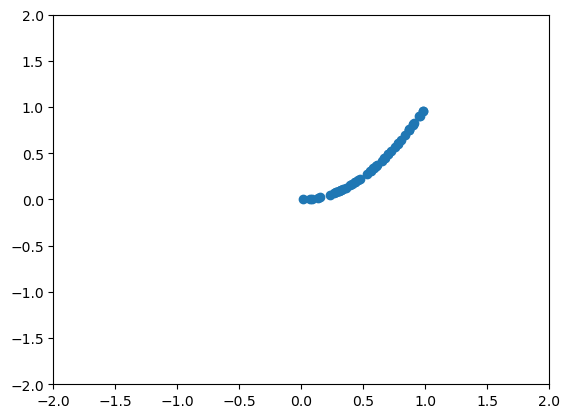

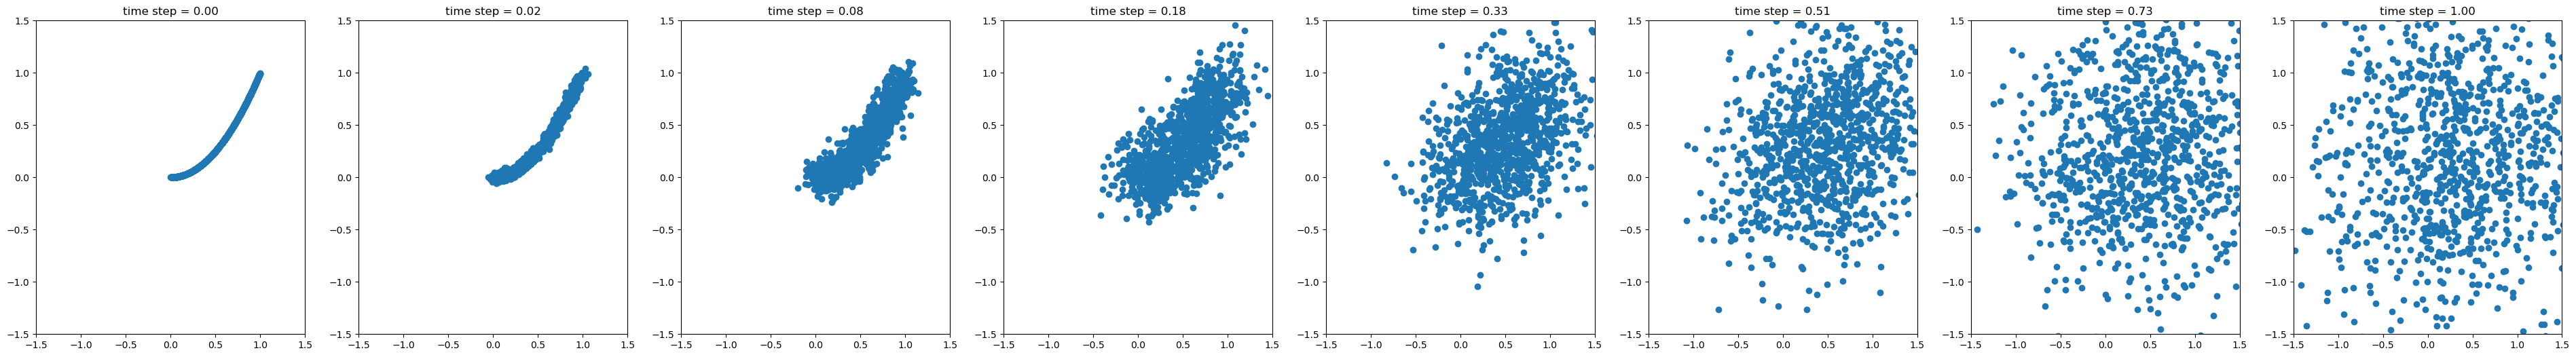

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
def manifold_func(x):
    return x**2

N_SAMPLES = 10000
x = torch.rand(size=(N_SAMPLES,))
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

fig, ax = plt.subplots()
ax.scatter(data[:50,0],data[:50,1])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
from torch.utils.data import Dataset, DataLoader
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = data[idx]
        return data_item

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
class ItoSDE(ABC):
    def __init__(self, T_max: float):
        self.T_max = T_max
    
    @abstractmethod
    def cond_exp(self, X_0: Tensor, t: Tensor):
        pass
        
    @abstractmethod
    def cond_var(self, X_0: Tensor, t: Tensor):
        pass
       
    @abstractmethod
    def f_drift(self, X_t: Tensor, t: Tensor):
        pass
        
    @abstractmethod
    def g_random(self, X_t: Tensor, t: Tensor):
        pass

    def cond_std(self, X_0: Tensor, t: Tensor):
        """Conditional standard deviation. Square root of self.cond_var."""
        return torch.sqrt(self.cond_var(X_0=X_0,t=t))
                   
    def sample_random_times(self, length: int):
        """Sample 'length' time points uniformly in interval [0,T]"""
        return torch.rand(size=(length,))*self.T_max
    
    @staticmethod
    def _mult_first_dim(t,X):
        """ 
        Helper function to multiply one-dimensional time vector with tensor of
        arbitrary shape.
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            has same shape as X_0 - inputs X_0[i] multipled with t[i]
        """
        return t.view(-1,*[1]*(X.dim()-1))*X
        
    def run_forward(self, X_0: Tensor, t: Tensor, clip_factor: float = 0.01):
        """
        Function to evolve SDE forward in time from 0 to t<=self.T_max.
        Assume that conditional distribution is Gaussian
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            X_t: shape as X_0 - noised input
            noise: shape as X_0 - noise converting X_0 to X_t
            score: shape as X_0 - score of conditional distribution q_t|0(X_t|X_0)
        """
        noise = torch.randn(size=X_0.shape)
        cond_std = self.cond_std(X_0,t)
        cond_exp = self.cond_exp(X_0,t)
        X_t = self._mult_first_dim(cond_std,noise)+cond_exp
        if clip_factor is not None:
            cond_std = torch.clip(cond_std,min=clip_factor)
        score = -self._mult_first_dim(1/cond_std,noise)

        return X_t, noise, score
        
    def run_forward_random_times(self, X_0: Tensor):
        """Function to evolve SDE forward until random times."""
        t = self.sample_random_times(X_0.shape[0])
        X_t, noise, score = self.run_forward(X_0,t)
        return X_t, noise, score, t

class VPSDE(ItoSDE):
    def __init__(self,T_max: float, beta_min: float = 0.0, beta_max: float = 1.0):
       self.T_max = T_max
       self.beta_min = beta_min
       self.beta_max = beta_max
        
    def _beta_derivative(self, t: Tensor):
        return self.beta_min+(self.beta_max - self.beta_min)*t
        
    def _beta(self, t: Tensor):
        return (self.beta_min*t)+0.5*(self.beta_max - self.beta_min)*(t**2)

    def cond_exp(self, X_0: Tensor, t: Tensor):
        """ 
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        assert t.shape[0] == X_0.shape[0]
        beta_t = self._beta(t)
        cond_exp_t = torch.exp(-0.5*beta_t)
        return self._mult_first_dim(cond_exp_t,X_0)

    def cond_var(self, X_0: Tensor, t: Tensor):
        """ 
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        #assert t.shape[0] == X_0.shape[0]
        beta_t = self._beta(t)
        cond_var_t = 1-torch.exp(-beta_t)
        return cond_var_t

    
    def f_drift(self, X_t: Tensor, t: Tensor):
        """ 
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        assert t.shape[0] == X_t.shape[0]
        deriv_beta_t = self._beta_derivative(t)
        return -0.5*self._mult_first_dim(deriv_beta_t,X_t)
        
    def g_random(self, t: Tensor):
        """ 
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        deriv_beta_t = self._beta_derivative(t)
        return torch.sqrt(deriv_beta_t)
sde = VPSDE(T_max=1,beta_min=0.01, beta_max=2.0)
n_grid_points = 8
time_vec = torch.linspace(0,1,n_grid_points)**2
X_0 = torch.stack([torch.stack([dataset.__getitem__(idx)]*n_grid_points) for idx in range(1000)]).transpose(1,0)
X_t, noise, score = sde.run_forward(X_0,time_vec)

fig, axs = plt.subplots(1,n_grid_points, figsize=(6*n_grid_points,6))
for idx in range(n_grid_points):
    axs[idx].scatter(X_t[idx,:,0],X_t[idx,:,1])
    axs[idx].set_xlim(-1.5,1.5)
    axs[idx].set_ylim(-1.5,1.5)
    axs[idx].set_title(f"time step = {time_vec[idx]:.2f}")


In [6]:
TRAIN_SCORE = False #whether to train score or denoiser network
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConnectedScoreModel(nn.Module):
    def __init__(self, data_dim: int = 2, hidden_dim: int = 128, n_hidden_layers: int = 2):
        super(FullConnectedScoreModel, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(data_dim+1, hidden_dim)
        self.input_batch_norm = nn.BatchNorm1d(hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            batch_norm = nn.BatchNorm1d(hidden_dim)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, data_dim)  # Assuming output is a single value

    def forward(self, x, t):
        x_conc_t = torch.concat([x,t.unsqueeze(1)],axis=1)
        x = F.relu(self.input_batch_norm(self.input_layer(x_conc_t)))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        return self.output_layer(x)
model = FullConnectedScoreModel()
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
N_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
def train_diffusion_model(model, sde: ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, train_score: bool = TRAIN_SCORE):
    model.train()
    model = model.to(device)
    loss_function = nn.MSELoss(reduction='mean')
    running_loss_list = []
    
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, x_inp in enumerate(dataloader):
            
            #Zero gradients:
            optimizer.zero_grad()
            
            #Run forward samples:
            X_t,noise,score,time = sde.run_forward_random_times(x_inp)

            #Send to device:
            X_t = X_t.to(device)
            noise = noise.to(device)
            time = time.to(device)
            
            #Predict score:
            model_pred = model(X_t,time)

            #Compute loss:
            if train_score:
                loss = loss_function(score,model_pred)
            else:
                loss = loss_function(noise,model_pred)

            #Optimize:
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.detach().item()
            
            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list
model,running_loss_list = train_diffusion_model(model, sde, trainloader, optimizer, device=device, n_epochs=N_EPOCHS, print_every=10)


Epoch: 0
1.0486342549324035
0.9486839234828949
0.7611134111881256
0.7207256019115448
0.6877443730831146
0.6335138201713562
0.575033575296402
Epoch: 1
0.49960875809192656
0.4978083223104477
0.460164287686348
0.39826485216617585
0.4146699130535126
0.4001215219497681
0.36030862629413607
Epoch: 2
0.3574424684047699
0.37224130630493163
0.3572037696838379
0.3402332752943039
0.3294325262308121
0.3272437512874603
0.3327276915311813
Epoch: 3
0.3197563111782074
0.28988091349601747
0.31069190353155135
0.2997574210166931
0.31604143679142
0.27276280522346497
0.32762370705604554
Epoch: 4
0.3071215569972992
0.2975513681769371
0.2928507298231125
0.3073196768760681
0.28749266266822815
0.29376005828380586
0.27563182413578036
Epoch: 5
0.3036197304725647
0.2557382181286812
0.2646738767623901
0.2910245954990387
0.2792932063341141
0.2672098994255066
0.2812411218881607
Epoch: 6
0.28112693727016447
0.2712573766708374
0.2860426902770996
0.27511646449565885
0.2510282501578331
0.2617243051528931
0.30226298868656

<Axes: >

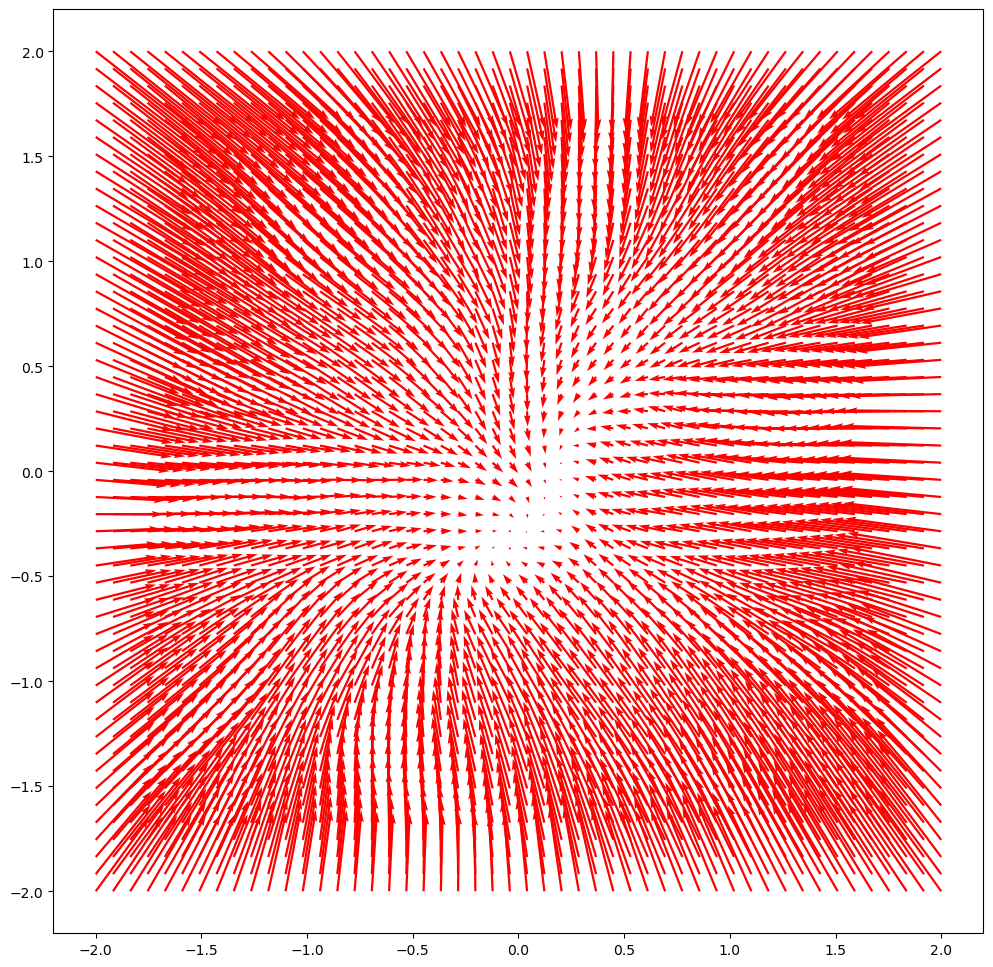

In [8]:
from typing import List, Callable
from itertools import product
def plot_score_vector_field(score_func: Callable, t: torch.Tensor, sde: VPSDE, min_x: float = -2.0, max_x: float = 2.0, n_grid_points: int = 50):
    oned_grid = torch.linspace(min_x, max_x, n_grid_points)
    x_grid, y_grid = torch.meshgrid(oned_grid, oned_grid)
    twod_grid = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)
    cond_std = sde.cond_var(twod_grid, t)
    t = t.expand(twod_grid.shape[0])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    score = -score_func(x=twod_grid, t=t)/cond_std
    score = score.detach().numpy()

    fig, my_axis = plt.subplots(figsize=(12,12))
    my_axis.quiver(twod_grid[:,0],twod_grid[:,1],score[:,0],score[:,1], scale=100000.0, color='r')
    return my_axis
model = model.to('cpu')
plot_score_vector_field(score_func=model, t=torch.tensor([0.01]), sde=sde)

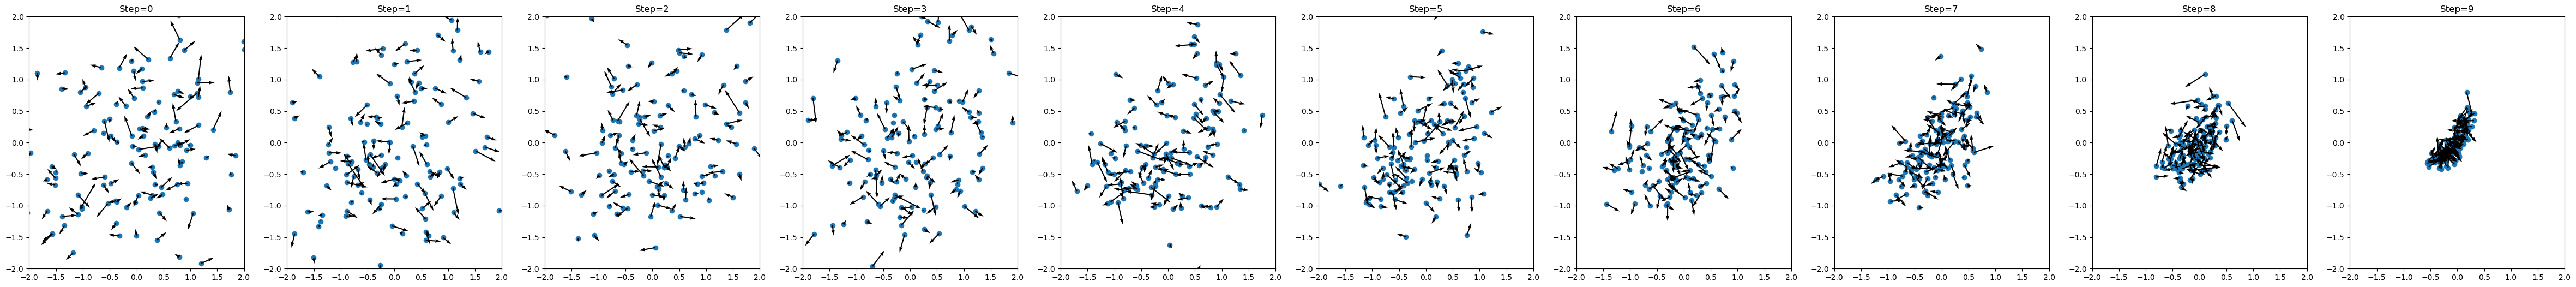

In [10]:
def run_backwards(model: torch.nn.Module, sde: ItoSDE, x_start: Tensor, device, train_score, n_steps: int = 10, plot_evolution: bool = True, clip_max: float = 1.0, clip_min: float = -1.0, **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    model = model.to(device)
    
    #Number of trajectories, dimension of data:
    n_traj = x_start.shape[0]
    ndim = x_start.dim()-1

    #Compute time grid for discretization and step size:
    time_grid = torch.linspace(sde.T_max,0,n_steps)
    step_size =torch.abs(time_grid[0]-time_grid[1])

    #Compute the random drift at every time point:
    random_drift_grid = sde.g_random(time_grid)
    
    #Sample random drift at every time point:
    noise = torch.randn(size=(n_steps,*list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise * random_drift_grid.view(-1,*[1]*(ndim+1))
    
    #Initialize list of trajectory:
    x_traj = [x_start]

    if plot_evolution:
        fig, axs = plt.subplots(1,len(time_grid),figsize=(6*len(time_grid),6))

    
    for idx,time in enumerate(time_grid):
        
        #Get last location and time
        x = x_traj[idx]
        t = time_grid[idx]
        time_vec = t.repeat(n_traj)
        
        #Deterministic drift: f(X_,t)
        determ_drift = step_size*sde.f_drift(x,time_vec)

        #Get random drift:
        random_drift_sample = random_drift_grid_sample[idx]

        #Get noise estimates:
        model_estimate = model(x.to(device),time_vec.to(device)).detach().cpu()

        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, time_vec),0.01)
            if len(model_estimate.shape) == 4:
                score_estimates = -model_estimate/denominator[:,None,None,None]
            else:
                score_estimates = -model_estimate/denominator[:,None]

        #Correction term: g^2 * score estimate
        g_squared = (random_drift_grid[idx]**2).repeat(n_traj)
        correction_term = (step_size*ItoSDE._mult_first_dim(g_squared,score_estimates))
        
        #Compute next step:
        change = (correction_term - determ_drift) + random_drift_sample
        next_step = x + change
        
        #Save step:
        x_traj.append(next_step)

        if plot_evolution:
            axs[idx].scatter(next_step[:,0],next_step[:,1])
            axs[idx].quiver(next_step[:,0],next_step[:,1],change[:,0],change[:,1])
            axs[idx].set_xlim(-2.0,2.0)
            axs[idx].set_ylim(-2.0,2.0)
            axs[idx].set_title(f"Step={idx}")
            
    output = torch.stack(x_traj) #.transpose(1,0)
    #output = torch.clip(output, clip_min, clip_max)
    return output,time_grid    

x_start = torch.randn(size=next(enumerate(trainloader))[1].shape)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device, train_score=TRAIN_SCORE)

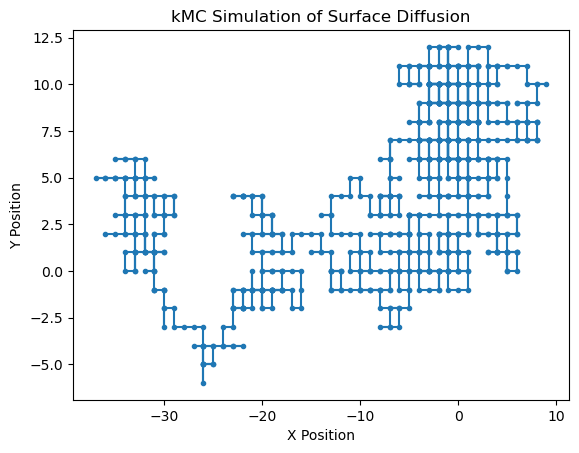

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义扩散事件
events = ['move_left', 'move_right', 'move_up', 'move_down']
rates = [1.0, 1.0, 0.5, 0.5]  # 假设的事件速率

def kMC_step(current_state):
    total_rate = sum(rates)
    r = np.random.rand() * total_rate
    cumulative = 0
    for event, rate in zip(events, rates):
        cumulative += rate
        if r < cumulative:
            # 更新状态
            if event == 'move_left':
                current_state[0] -= 1
            elif event == 'move_right':
                current_state[0] += 1
            elif event == 'move_up':
                current_state[1] += 1
            elif event == 'move_down':
                current_state[1] -= 1
            break
    # 计算时间步长
    delta_t = -np.log(np.random.rand()) / total_rate
    return current_state, delta_t

# 初始化
state = [0, 0]
time = 0
trajectory = [state.copy()]
times = [time]

# 模拟
for _ in range(1000):
    state, delta_t = kMC_step(state)
    time += delta_t
    trajectory.append(state.copy())
    times.append(time)

# 可视化轨迹
trajectory = np.array(trajectory)
plt.plot(trajectory[:,0], trajectory[:,1], marker='.', linestyle='-')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('kMC Simulation of Surface Diffusion')
plt.show()


d:\Anaconda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26391 (\N{CJK UNIFIED IDEOGRAPH-6717}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36816 (\N{CJK UNIFIED IDEOGRAPH-8FD0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33945 (\N{CJK UNIFIED IDEOGRAPH-8499}) missing from font(s) DejaVu San

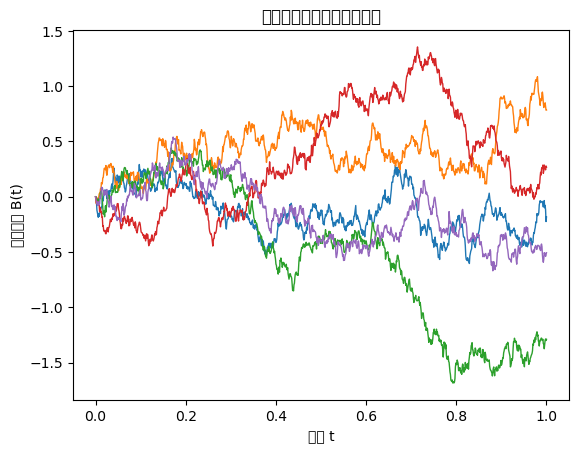

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_brownian_motion(T, N, M):
    dt = T / N
    # 生成M条布朗运动路径
    dB = np.random.normal(0, np.sqrt(dt), size=(M, N))
    B = np.cumsum(dB, axis=1)
    B = np.hstack((np.zeros((M, 1)), B))  # 添加初始点B(0)=0
    return B

# 参数设置
T = 1.0    # 时间区间 [0, T]
N = 1000   # 时间步数
M = 5      # 模拟路径数量

# 模拟布朗运动
B = monte_carlo_brownian_motion(T, N, M)

# 绘制路径
time = np.linspace(0, T, N+1)
for i in range(M):
    plt.plot(time, B[i], lw=1)
plt.xlabel('时间 t')
plt.ylabel('布朗运动 B(t)')
plt.title('蒙特卡洛方法模拟布朗运动')
plt.show()


In [ ]:
vscode-remote://ssh-remote%2Bn0docker/home/data/Diffusion/mnist_diffusion_classifier.ckpt